In [ ]:
# ABOUTME: Generate MCMC ground truth reference posteriors for cosmology power spectrum task
# ABOUTME: Uses emcee sampler to create reference samples on 20x20 grid

import numpy as np
import torch
import random

SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)

In [1]:
import numpy as np
import emcee
import matplotlib.pyplot as plt
import symbolic_pofk.syren_new as syren_new
from scipy.stats import truncnorm
import os
from ili.utils.distributions_pt import CustomIndependent
from tqdm import tqdm
import corner

/home/x-ctirapongpra/.conda/envs/2024.02-py311/tailed-uniform/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Global constants
L, N = 1000, 64
kf = 2*np.pi/L
knyq = np.pi*N/L
kedges = np.arange(0, knyq, kf)
kcenters = (kedges[:-1] + kedges[1:])/2
a = 1.0

# Original parameter ranges
param_1_range = (0.27, 0.37)   # Om
param_2_range = (0.63, 0.71)    # h

param_1_half_width = (param_1_range[1] - param_1_range[0]) / 2
param_2_half_width = (param_2_range[1] - param_2_range[0]) / 2

# Prior parameters
param_1_mean = (param_1_range[0] + param_1_range[1]) / 2  # Om mean
param_2_mean = (param_2_range[0] + param_2_range[1]) / 2  # h mean
param_1_std = 0.1 * (param_1_range[1] - param_1_range[0])   # Om std
param_2_std = 0.1 * (param_2_range[1] - param_2_range[0])   # h std

In [ ]:
def forward_model_deterministic(theta):
    """
    Deterministic forward model: theta -> P_theory(k)
    Returns noiseless theoretical power spectrum

    Args:
        theta: [Om, h] cosmological parameters
    Returns:
        P_theory: theoretical power spectrum (no noise)
    """
    Om, h = theta

    # Fixed cosmological parameters
    As = 2.105  # 10^9 A_s
    Ob = 0.02242 / h ** 2
    ns = 0.9665
    w0 = -1.0
    wa = 0.0
    mnu = 0.0

    # Get theoretical power spectrum (no noise)
    pk_syren_theory = syren_new.pnl_new_emulated(
        kcenters, As, Om, Ob, h, ns, mnu, w0, wa, a=a
    )

    return pk_syren_theory


def compute_cosmic_variance_std(P_theory):
    """
    Compute cosmic variance uncertainties for power spectrum

    Args:
        P_theory: theoretical power spectrum
    Returns:
        std_mode: standard deviation per k-bin
    """
    var_single = np.abs(P_theory)**2
    Nk = L**3 * kcenters**2 * kf / (2*np.pi**2)
    var_mode = var_single * 2 / Nk
    std_mode = np.sqrt(var_mode)
    return std_mode


def log_prior(theta):
    """
    Log prior probability (Normal distributions)

    Args:
        theta: [Om, h] parameters
    Returns:
        log_prior: log prior probability
    """
    Om, h = theta

    if Om < 0.24 or Om > 0.40:
        return -np.inf
    if h < 0.61 or h > 0.73:
        return -np.inf

    # Normal prior for Om
    log_prior_Om = -0.5 * ((Om - param_1_mean) / param_1_std)**2

    # Normal prior for h
    log_prior_h = -0.5 * ((h - param_2_mean) / param_2_std)**2

    return log_prior_Om + log_prior_h


def log_likelihood(theta, x_obs):
    """
    Log likelihood function

    Args:
        theta: [Om, h] parameters
        x_obs: observed power spectrum data
    Returns:
        log_likelihood: log likelihood value
    """
    # Forward model
    P_theory = forward_model_deterministic(theta)

    # Noise model
    std_mode = compute_cosmic_variance_std(P_theory)

    # Gaussian likelihood
    log_like = -0.5 * np.sum(((x_obs - P_theory) / std_mode)
                             ** 2) - np.sum(np.log(std_mode))

    return log_like

# log ratio = log like1 - log like2


def log_probability(theta, x_obs):
    """
    Log posterior probability

    Args:
        theta: [Om, h] parameters
        x_obs: observed power spectrum data
    Returns:
        log_posterior: log posterior probability
    """
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf

    return lp + log_likelihood(theta, x_obs)

In [4]:
def run_mcmc_inference(
        x_obs, num_samples=1000, warmup_steps=500, num_chains=4,
        verbose=True):
    """
    Run MCMC inference using emcee sampler

    Args:
        x_obs: observed power spectrum data (numpy array)
        num_samples: number of MCMC samples per chain
        warmup_steps: number of warmup steps
        num_chains: number of parallel walkers

    Returns:
        samples: dictionary of parameter samples
        sampler: emcee sampler object for diagnostics
    """
    # Ensure x_obs is numpy array
    if not isinstance(x_obs, np.ndarray):
        x_obs = np.array(x_obs)

    # Initialize walkers with random positions within prior range
    pos = np.random.rand(num_chains, 2)
    pos[:, 0] = pos[:, 0] * \
        (param_1_range[1] - param_1_range[0]) + param_1_range[0]  # Om
    pos[:, 1] = pos[:, 1] * \
        (param_2_range[1] - param_2_range[0]) + param_2_range[0]  # h

    # Set up sampler
    sampler = emcee.EnsembleSampler(
        num_chains, 2, log_probability, args=(x_obs,))

    if verbose:
        print(
            f"Running MCMC with {num_samples} samples, {warmup_steps} warmup steps, {num_chains} walkers...")
        print(
            f"Om range: [{param_1_range[0]:.4f}, {param_1_range[1]:.4f}], std: {param_1_std:.4f}")
        print(
            f"h range:  [{param_2_range[0]:.4f}, {param_2_range[1]:.4f}], std: {param_2_std:.4f}")

    # Run warmup
    state = sampler.run_mcmc(pos, warmup_steps)
    sampler.reset()

    # Run production
    sampler.run_mcmc(state, num_samples)

    # Extract samples
    chain = sampler.get_chain(flat=True)
    samples_np = {
        'Om': chain[:, 0],
        'h': chain[:, 1]
    }

    return samples_np, sampler

In [5]:
# theta_true = np.array([0.40, 0.61])  # [Om, h]
# theta_true = np.array([0.24, 0.61])  # [Om, h]
# theta_true = np.array([0.40, 0.73])  # [Om, h]
theta_true = np.array([0.27, 0.71])  # [Om, h]

# Get noiseless prediction
P_theory_true = forward_model_deterministic(theta_true)

# Get noise level
std_true = compute_cosmic_variance_std(P_theory_true)

# Add noise
x_obs = P_theory_true + std_true * np.random.randn(*P_theory_true.shape)



# Run MCMC inference
samples, sampler = run_mcmc_inference(
    x_obs,
    num_samples=2000,      # samples per walker
    warmup_steps=500,       # burn-in steps
    num_chains=4           # number of walkers (should be >= 2*ndim)
)

print(f"True Om: {theta_true[0]:.3f}, Mean Om: {np.mean(samples['Om']):.3f}")
print(f"True h:  {theta_true[1]:.3f}, Mean h:  {np.mean(samples['h']):.3f}")

Running MCMC with 2000 samples, 500 warmup steps, 4 walkers...
Om range: [0.2700, 0.3700], std: 0.0100
h range:  [0.6300, 0.7100], std: 0.0080


True Om: 0.270, Mean Om: 0.290
True h:  0.710, Mean h:  0.691


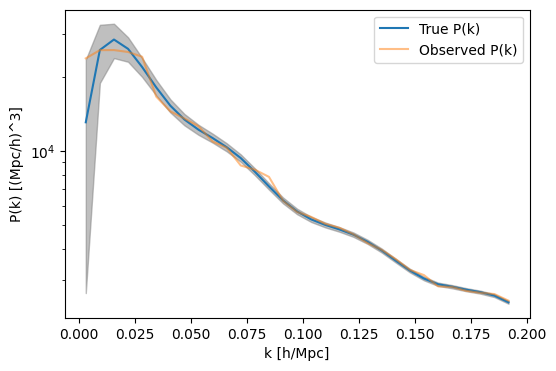

In [6]:
f, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.semilogy()
ax.plot(kcenters, P_theory_true, label='True P(k)')
ax.plot(kcenters, x_obs, label='Observed P(k)', alpha=0.5)
ax.fill_between(kcenters, P_theory_true - std_true,
                P_theory_true + std_true, color='gray', alpha=0.5)
ax.set_xlabel('k [h/Mpc]')
ax.set_ylabel('P(k) [(Mpc/h)^3]')
ax.legend()

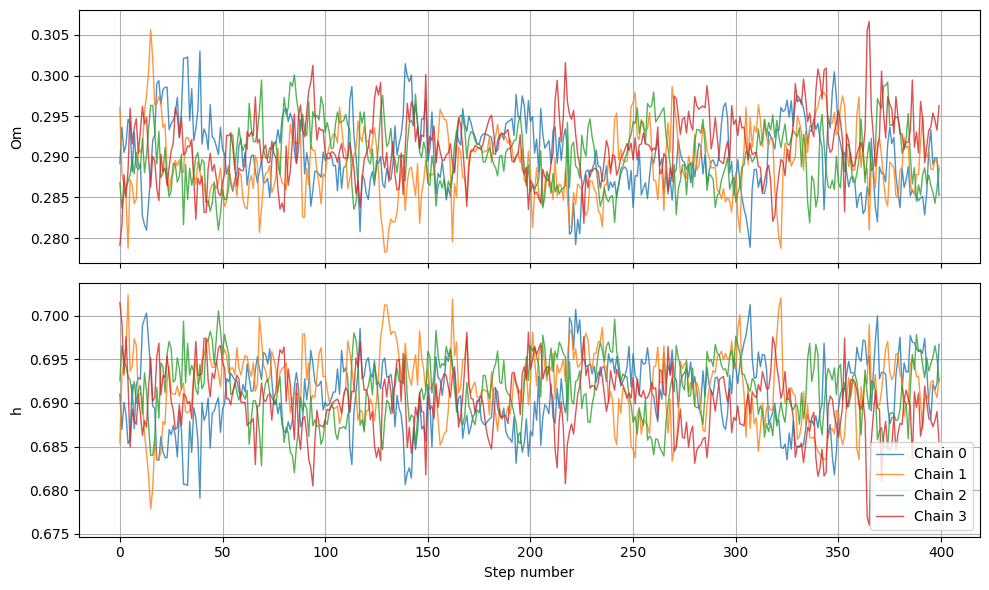

In [7]:
chain = sampler.get_chain()
fig, axes = plt.subplots(2, 1, figsize=(10, 6), sharex=True)
labels = ["Om", "h"]
subsample = 5

for i in range(2):
    ax = axes[i]
    for walker in range(chain.shape[1]):
        ax.plot(chain[::subsample, walker, i],
                alpha=0.8, lw=1, label=f'Chain {walker}')
    ax.set_ylabel(labels[i])
    ax.grid()

axes[-1].set_xlabel("Step number")
axes[-1].legend()
plt.tight_layout()
plt.show()

In [10]:
# Save MCMC samples to disk
output_dir = "/home/x-ctirapongpra/scratch/tailed-uniform-sbi/mcmc_samples/test_edge"
os.makedirs(output_dir, exist_ok=True)

# Save as numpy array
samples_array = np.column_stack([samples['Om'], samples['h']])
np.save(os.path.join(output_dir, "mcmc_samples.npy"), samples_array)

# Also save metadata
metadata = {
    'theta_true': theta_true,
    'num_samples': len(samples['Om']),
    'param_names': ['Om', 'h'],
    'param_ranges': [param_1_range, param_2_range],
}
np.save(os.path.join(output_dir, "mcmc_metadata.npy"), metadata)

print(f"Saved {len(samples['Om'])} MCMC samples to {output_dir}/")
print(f"  - mcmc_samples.npy: shape {samples_array.shape}")
print(f"  - mcmc_metadata.npy: metadata dictionary")

Saved 8000 MCMC samples to /home/x-ctirapongpra/scratch/tailed-uniform-sbi/mcmc_samples/test_edge/
  - mcmc_samples.npy: shape (8000, 2)
  - mcmc_metadata.npy: metadata dictionary


In [11]:
def create_grid_test_points(n_points_per_dim=20):
    """Create test points on rectangular grid"""
    Om_points = np.linspace(param_1_range[0], param_1_range[1], n_points_per_dim)
    h_points = np.linspace(param_2_range[0], param_2_range[1], n_points_per_dim)

    test_points = []
    for Om in Om_points:
        for h in h_points:
            test_points.append([Om, h])

    return np.array(test_points)

output_dir = "/home/x-ctirapongpra/scratch/tailed-uniform-sbi/mcmc_samples/grid"
os.makedirs(output_dir, exist_ok=True)

n_points_per_dim = 20
test_points = create_grid_test_points(n_points_per_dim)

In [ ]:
# Storage for results
all_samples = []
all_observations = []

# Run MCMC for each test point
for idx, theta_true in enumerate(tqdm(test_points, desc="Running MCMC grid")):
    # Generate observation
    P_theory_true = forward_model_deterministic(theta_true)
    std_true = compute_cosmic_variance_std(P_theory_true)
    x_obs = P_theory_true + std_true * np.random.randn(*P_theory_true.shape)
    
    # Impute nans
    mask = np.isnan(x_obs)
    x_obs[mask] = np.nanmean(x_obs)
    # Run MCMC inference
    samples, sampler = run_mcmc_inference(
        x_obs,
        num_samples=2000,      # samples per walker
        warmup_steps=500,      # burn-in steps
        num_chains=4,          # number of walkers
        verbose=False
    )

    # Store results
    samples_array = np.column_stack([samples['Om'], samples['h']])
    all_samples.append(samples_array)
    all_observations.append(x_obs)

    # Save intermediate results every 50 points
    if (idx + 1) % 50 == 0:
        print(f"\nSaved intermediate results for {idx + 1} points")
        np.save(os.path.join(output_dir, f"mcmc_samples_partial_{idx+1}.npy"),
                np.array(all_samples))
        np.save(os.path.join(output_dir, f"observations_partial_{idx+1}.npy"),
                np.array(all_observations))

# Convert to numpy arrays
all_samples = np.array(all_samples)  # Shape: (400, 8000, 2)
all_observations = np.array(all_observations)  # Shape: (400, n_k_bins)

# Save final results
np.save(os.path.join(output_dir, "mcmc_samples.npy"), all_samples)
np.save(os.path.join(output_dir, "observations.npy"), all_observations)
np.save(os.path.join(output_dir, "test_points.npy"), test_points)

Running MCMC grid:  12%|█▎        | 50/400 [03:14<22:42,  3.89s/it]


Saved intermediate results for 50 points


Running MCMC grid:  25%|██▌       | 100/400 [06:29<19:30,  3.90s/it]


Saved intermediate results for 100 points


Running MCMC grid:  38%|███▊      | 150/400 [09:44<16:20,  3.92s/it]


Saved intermediate results for 150 points


Running MCMC grid:  50%|█████     | 200/400 [12:59<12:59,  3.90s/it]


Saved intermediate results for 200 points


Running MCMC grid:  62%|██████▎   | 250/400 [16:14<09:43,  3.89s/it]


Saved intermediate results for 250 points


Running MCMC grid:  75%|███████▌  | 300/400 [19:28<06:30,  3.90s/it]


Saved intermediate results for 300 points


Running MCMC grid:  88%|████████▊ | 350/400 [22:44<03:15,  3.91s/it]


Saved intermediate results for 350 points


Running MCMC grid: 100%|██████████| 400/400 [25:58<00:00,  3.90s/it]


Saved intermediate results for 400 points

Saving final results...
